# Main Script to Load, Transform and Analyse data for Final Assigment

## Data load from local file "HM Land Registry - Price Paid Data property sales in Greater London - Raw Data.csv"

# Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import locale # Used 
import yaml # Used to manage configuration Parameters, I'm using it at work and it's so easy to set configurable constant values 

# Loading config file

In [2]:
cnf_file = open(f"config.yaml", 'r')
conf_dictionary = yaml.full_load(cnf_file)
config = conf_dictionary["default"]

# Load data from CSV file

In [3]:
df1 = pd.read_csv("Property sales in Greater London - 2018 - 2019.csv", parse_dates=[config['parse_dates']], dayfirst=False)
df2 = pd.read_csv("Property sales in Greater London - 2020 - 2023.csv", parse_dates=[config['parse_dates']], dayfirst=True)

# Merging both dataframes

In [4]:
df = pd.concat([df1, df2])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489352 entries, 0 to 287274
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   unique_id             489352 non-null  object        
 1   price_paid            489352 non-null  int64         
 2   deed_date             489352 non-null  datetime64[ns]
 3   postcode              488916 non-null  object        
 4   property_type         489352 non-null  object        
 5   new_build             489352 non-null  object        
 6   estate_type           489352 non-null  object        
 7   saon                  183047 non-null  object        
 8   paon                  489352 non-null  object        
 9   street                489312 non-null  object        
 10  locality              31256 non-null   object        
 11  town                  489352 non-null  object        
 12  district              489352 non-null  object        
 13 

# Renaming columns from both DFs

In [5]:
keys   = ['unique_id','price_paid','deed_date','postcode','property_type','new_build','estate_type','saon','paon','street','locality','town','district','county','transaction_category','linked_data_uri']
values = ['Id','Value','Purchased Date','Postcode','Property Type','New Build','Estate Type','Saon','Paon','Street','Locality','Town','District','County','Transaction Category','URL']
dict_cols = dict(zip(keys, values))
df.rename(columns=dict_cols, inplace=True)

### Ordering and Cleansing the data

In [7]:
col_order = ['Id','Purchased Date','Postcode','Property Type','Value','New Build','Estate Type','Transaction Category','Saon','Paon','Street','Locality','Town','District','County','URL']
df = df[col_order]
for col in ['Saon','Paon','Street','Locality','Town','District','County']:
    df[col] = df[col].str.title()
    
# Renaming values on Property Type
property_type_replace = {'D': 'Detached', 'S': 'Semi-Detached', 'T': 'Terraced', 'F': 'Flats/Maisonettes', 'O': 'Other'}
df.replace({"Property Type": property_type_replace}, inplace=True)

# Renaming values on New properties as False, True
df.replace({'New Build': {'Y': True, 'N': False}}, inplace=True)

# Renaming Transaction Category
df.replace({'Transaction Category': {'A': 'Standard Price Paid', 'B': 'Additional Price Paid'}}, inplace=True)

# Renaming Duration tenancy
df.replace({'Estate Type': {'F': 'Freehold', 'L': 'Leasehold'}}, inplace=True)

# Removing properties under £10.000
df = df.drop(df[df.Value <= 10000].index)

df.to_csv("Property Sales in Greater London - Merged.csv", index=False)

# Explore the data

In [8]:
print("Dataframe head:")
print(df.head())

print("Dataframe shape:")
print(df.shape )

print("Dataframe columns:")
print(df.columns)


Dataframe head:
                                     Id Purchased Date Postcode  \
0  7E86B6FB-423C-458C-E053-6B04A8C0C84C     2018-11-30  BR1 1AA   
1  9DBAD222-2B0C-6EB3-E053-6B04A8C0F257     2019-12-09  BR1 1AB   
2  965B6D91-D514-95E4-E053-6C04A8C07729     2019-10-16  BR1 1AE   
3  7E86B6FB-4232-458C-E053-6B04A8C0C84C     2018-11-23  BR1 1AF   
4  9FF0D96A-1CCA-11ED-E053-6C04A8C06383     2019-07-05  BR1 1AF   

       Property Type   Value  New Build Estate Type   Transaction Category  \
0  Flats/Maisonettes   99000      False   Leasehold    Standard Price Paid   
1  Flats/Maisonettes  445000      False   Leasehold    Standard Price Paid   
2  Flats/Maisonettes  255000      False   Leasehold  Additional Price Paid   
3  Flats/Maisonettes  400000      False   Leasehold    Standard Price Paid   
4  Flats/Maisonettes  380000      False   Leasehold    Standard Price Paid   

          Saon                     Paon        Street Locality     Town  \
0      Flat 28              Henry Hou

# Index of Property Market - Yearly Variation

### Convert date column to datetime format, set it as index and create a Year column out of it

In [9]:
df['Purchased Date'] = pd.to_datetime(df['Purchased Date'])
df.set_index('Purchased Date', inplace=True)
df['Year'] = df.index.year

### Set date column as the index

### Group data by year, aggregate by value and plot this

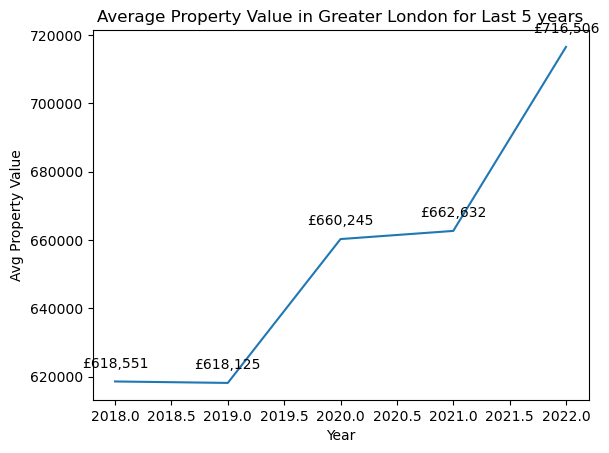

In [10]:
# df_avg = df.groupby('Year')['Value'].mean()
# Eg: df.groupby('kind').agg(min_height=('height', 'min'), max_weight=('weight', 'max'))
df_avg = df.groupby('Year').agg(Value=('Value', 'mean'), max=('Value', 'max'), min=('Value', 'min'), count=('Id','count'))

# Set the locale to display the currency format
locale.setlocale(locale.LC_ALL, '')

plt.plot(df_avg.index, df_avg['Value'])
plt.xlabel('Year')
plt.ylabel('Avg Property Value')
plt.title('Average Property Value in Greater London for Last 5 years')

# zip joins x and y coordinates in pairs
plt.rcParams.update({'axes.ymargin': 0.2})
plt.rcParams.update({'axes.xmargin': 0.5})
for x,y in zip(df_avg.index, df_avg['Value']):
    label = "{:.0f}".format(y)
    label = locale.currency(y, grouping=True)[:-3]
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 annotation_clip=False) # horizontal alignment can be left, right or center

F = plt.gcf() # To increase the width of the graph.
Size = F.get_size_inches()
# F.set_size_inches(Size[0]*1.2, Size[1]*1, forward=True)
plt.show()

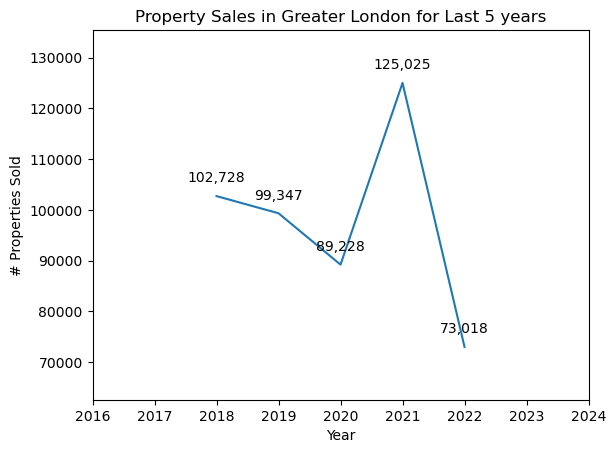

In [18]:

plt.plot(df_avg.index, df_avg['count'])
plt.xlabel('Year')
plt.ylabel('# Properties Sold')
plt.title('Property Sales in Greater London for Last 5 years')

# zip joins x and y coordinates in pairs
plt.rcParams.update({'axes.ymargin': 0.2})
plt.rcParams.update({'axes.xmargin': 0.5})
for x,y in zip(df_avg.index, df_avg['count']):
    label = "{:.0f}".format(y)
    label = locale.format_string('%.0f', val=y, grouping=True, monetary=False)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 annotation_clip=False) # horizontal alignment can be left, right or center

F = plt.gcf() # To increase the width of the graph.
Size = F.get_size_inches()
# F.set_size_inches(Size[0]*1.2, Size[1]*1, forward=True)
plt.show()

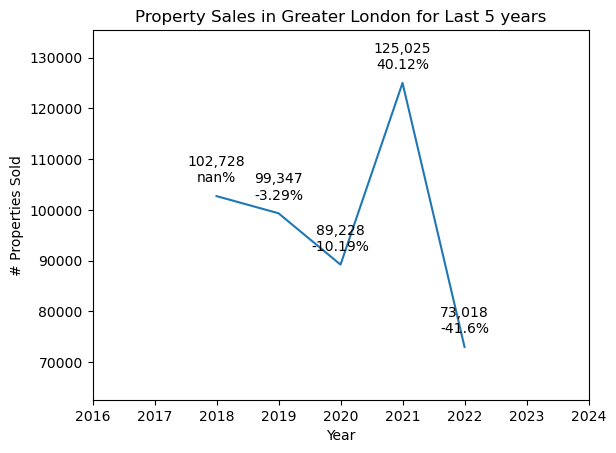

In [19]:

pct_var = df_avg['count'].pct_change() * 100

plt.plot(df_avg.index, df_avg['count'])
plt.xlabel('Year')
plt.ylabel('# Properties Sold')
plt.title('Property Sales in Greater London for Last 5 years')

# zip joins x and y coordinates in pairs
plt.rcParams.update({'axes.ymargin': 0.2})
plt.rcParams.update({'axes.xmargin': 0.5})
for x,y,var in zip(df_avg.index, df_avg['count'], pct_var):
    label = "{:.0f}".format(y)
    label = locale.format_string('%.0f', val=y, grouping=True, monetary=False)
    plt.annotate(label + '\n' + str(round(var,2)) + '%', # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 annotation_clip=False) # horizontal alignment can be left, right or center

F = plt.gcf() # To increase the width of the graph.
Size = F.get_size_inches()
# F.set_size_inches(Size[0]*1.2, Size[1]*1, forward=True)
plt.show()

In [ ]:
# create subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# plot data on each subplot
for i, col in enumerate(["min", "max"]):
    ax = axs[i]
    ax.bar(df_avg.index, df_avg[col])
    ax.set_xlabel("Index")
    ax.set_ylabel(col)
    ax.set_xticklabels(df_avg.index, rotation=45, ha="right")
    
    # add bar labels
    labels = 'df["% of Total in A"]'
    ax.bar_label(ax.containers[-1], labels=labels, label_type="center")
    
# adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# show plot
plt.show()

In [ ]:
# create subplots
fig, ax = plt.subplots(1, 2)

# plot data on subplots
df_avg.plot(use_index=True, y=["min", "max"], kind="bar", ax=ax)

# loop through subplots and containers to add labels
for i, axes in enumerate(ax):
    for container in axes.containers:
        ax[i].bar_label(container, labels=df['% of Total in A'])

# show plot
plt.show()

In [ ]:
# your colors
colors = ['#5cb85c', '#5bc0de', '#d9534f']

# plot with annotations is probably easier
p1 = df_avg.plot(kind='bar', use_index=True, color=colors, figsize=(20, 8), rot=0, ylabel='Percentage', title="The percentage of the respondents' interest in the different data science Area")

for p in p1.containers:
    p1.bar_label(p, fmt='%.2f', label_type='edge')

In [ ]:
### Increase in Percentage per year

In [ ]:
fst_avg_price = df_avg.Value.iloc[0]
normalized = df_avg.Val
dogs.groupby(["color","breed"])["weight_kg"].mean()

df_avg = df.Value.div(
    

# Set the locale to display the currency format
locale.setlocale(locale.LC_ALL, '')

plt.plot(df_avg.index, df_avg.values)
plt.xlabel('Year')
plt.ylabel('Avg Property Value')
plt.title('Average Property Value in Greater London for Last 5 years')
# zip joins x and y coordinates in pairs
plt.rcParams.update({'axes.ymargin': 0.2})
plt.rcParams.update({'axes.xmargin': 0.5})
for x,y in zip(df_avg.index, df_avg.values):

    label = "{:.0f}".format(y)
    label = locale.currency(y, grouping=True)[:-3]
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 annotation_clip=False) # horizontal alignment can be left, right or center

F = plt.gcf() # To increase the width of the graph.
Size = F.get_size_inches()
F.set_size_inches(Size[0]*1.2, Size[1]*1, forward=True)
plt.show()

# Aggregate data by Year, District and 

In [ ]:
# group data by year and type and compute the avg of the numeric column
grouped = df.groupby(['Year', 'District']).agg({'Value': 'mean'})
# df.info()

In [ ]:

# reset the index to convert the resulting DataFrame back to a regular format
grouped = grouped.reset_index()

# format the values as currency using applymap
# grouped = grouped.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
grouped["Value"] = grouped.Value.astype(float)
# grouped.info()

In [ ]:
sns.lineplot(x=df["Year"],y=df["Value"],hue=df["District"])
# grouped.plot(x="Year", y="District");

In [ ]:
# plot the resulting DataFrame using seaborn
sns.catplot(x='District', y='Value', hue='Year', kind='bar', data=grouped, height=6, aspect=2)

# set the tick labels to display the formatted currency values
ax = plt.gca()
for i, tick in enumerate(ax.get_yticklabels()):
    tick.set_text(grouped.iloc[i]['Value'])
    ax.set_yticklabels(ax.get_yticklabels())

plt.show()

### Calculate the average of a numeric column for each year

In [ ]:

grouped_by_year = df.asfreq('Y')


In [ ]:
averages_per_year = grouped_by_year['Value'].aggregate('mean')

In [ ]:
averages_per_year.head()

In [ ]:
# Compare annual avg price trends

In [ ]:
config['years_to_aggregate']

In [ ]:
avg_values = pd.DataFrame()

# Select data for each year and concatenate with avg. property values 
for year in years_to_aggregate:
    value_per_year = df.loc[year, ['Value']].reset_index(drop=True)
    value_per_year.rename(columns={'Value': year}, inplace=True)
    avg_values = pd.concat([prices, value_per_year], axis=1)

# Plot prices
avg_values.plot(subplots=True)
plt.tight_layout(); plt.show()